In [ ]:
! pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"hazelerturk","key":"1223c021b72b14116a6d3dd04a73bb8c"}'}

In [ ]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

pneumonia-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip pneumonia-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/normal/IM-0435-0001-0001.jpeg  
  inflating: train/normal/IM-0435-0001.jpeg  
  inflating: train/normal/IM-0437-0001-0001.jpeg  
  inflating: train/normal/IM-0437-0001-0002.jpeg  
  inflating: train/normal/IM-0437-0001.jpeg  
  inflating: train/normal/IM-0438-0001.jpeg  
  inflating: train/normal/IM-0439-0001-0001.jpeg  
  inflating: train/normal/IM-0439-0001-0002.jpeg  
  inflating: train/normal/IM-0439-0001.jpeg  
  inflating: train/normal/IM-0440-0001.jpeg  
  inflating: train/normal/IM-0441-0001.jpeg  
  inflating: train/normal/IM-0442-0001.jpeg  
  inflating: train/normal/IM-0444-0001.jpeg  
  inflating: train/normal/IM-0445-0001.jpeg  
  inflating: train/normal/IM-0446-0001.jpeg  
  inflating: train/normal/IM-0447-0001.jpeg  
  inflating: train/normal/IM-0448-0001.jpeg  
  inflating: train/normal/IM-0449-0001.jpeg  
  inflating: train/normal/IM-0450-0001.jpeg  
  inflating: train/normal/IM-0451-0001.jpeg  
  in

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np              
import pandas as pd             

In [ ]:
train_path = '/content/train'
test_path = '/content/test'
valid_path = '/content/val'

In [ ]:
batch_size = 16

In [ ]:
img_height = 500
img_width = 500
color_channel = 1

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


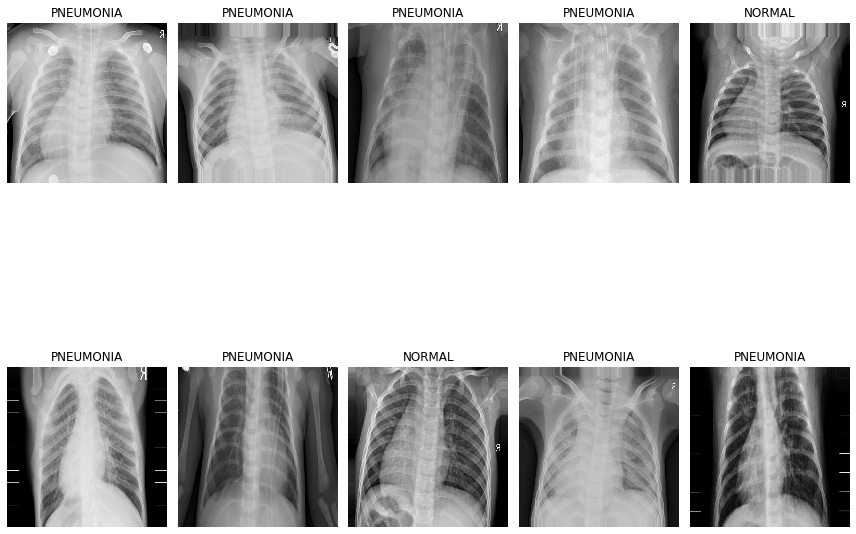

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, callbacks=callbacks_list)

Epoch 1/25
 17/262 [>.............................] - ETA: 20:30 - loss: 0.6040 - accuracy: 0.7831

KeyboardInterrupt: ignored

# Training takes more than 5 hours.